<a href="https://colab.research.google.com/github/NeoNeuron/CCN2021_TUT/blob/main/LIF.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>

---
# Leaky Integrate-and-Fire Neuron Model

**Content Creator:** Yuxiu Shao

## Tutorial Objectives

In this tutorial, we will build up a leaky integrate-and-fire (LIF) neuron model and study its dynamics in response to various types of inputs. In particular, we are going to write a few lines of code to:  

- simulate the LIF neuron model (done!)
 
- drive the LIF neuron with external inputs, such as direct currents (done!), Gaussian white noise (done!), and Poisson spike trains, etc.

In [1]:
# import package 
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# @title Figure Settings
import ipywidgets as widgets  
# interactive display
%config InlineBackend.figure_format = 'retina'
my_layout = widgets.Layout()

In [2]:
# @title Helper functions


def plot_volt_trace(pars, v, sp):
  """
  Plot trajetory of membrane potential for a single neuron

  Expects:
  pars   : parameter dictionary
  v      : volt trajetory
  sp     : spike train

  Returns:
  figure of the membrane potential trajetory for a single neuron
  """

  V_th = pars['V_th']
  dt, range_t = pars['dt'], pars['range_t']
  if sp.size:
    sp_num = (sp / dt).astype(int) - 1
    v[sp_num] += 20  # draw nicer spikes

  plt.plot(pars['range_t'], v, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--')
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
             loc=[1.05, 0.75])
  plt.ylim([-80, -40])


def plot_GWN(pars, I_GWN):
  """
  Args:
    pars  : parameter dictionary
    I_GWN : Gaussian white noise input

  Returns:
    figure of the gaussian white noise input
  """

  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(pars['range_t'][::3], I_GWN[::3], 'b')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$I_{GWN}$ (pA)')
  plt.subplot(122)
  plot_volt_trace(pars, v, sp)
  plt.tight_layout()


def my_hists(isi1, isi2, cv1, cv2, sigma1, sigma2):
  """
  Args:
    isi1 : vector with inter-spike intervals
    isi2 : vector with inter-spike intervals
    cv1  : coefficient of variation for isi1
    cv2  : coefficient of variation for isi2

  Returns:
    figure with two histograms, isi1, isi2

  """
  plt.figure(figsize=(11, 4))
  my_bins = np.linspace(10, 30, 20)
  plt.subplot(121)
  plt.hist(isi1, bins=my_bins, color='b', alpha=0.5)
  plt.xlabel('ISI (ms)')
  plt.ylabel('count')
  plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma1, cv1))

  plt.subplot(122)
  plt.hist(isi2, bins=my_bins, color='b', alpha=0.5)
  plt.xlabel('ISI (ms)')
  plt.ylabel('count')
  plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma2, cv2))
  plt.tight_layout()
  plt.show()


# the function plot the raster of the Poisson spike train
def my_raster_Poisson(range_t, spike_train, n):
  """
  Generates poisson trains

  Args:
    range_t     : time sequence
    spike_train : binary spike trains, with shape (N, Lt)
    n           : number of Poisson trains plot

  Returns:
    Raster plot of the spike train
  """

  # find the number of all the spike trains
  N = spike_train.shape[0]

  # n should smaller than N:
  if n > N:
    print('The number n exceeds the size of spike trains')
    print('The number n is set to be the size of spike trains')
    n = N

  # plot rater
  i = 0
  while i < n:
    if spike_train[i, :].sum() > 0.:
      t_sp = range_t[spike_train[i, :] > 0.5]  # spike times
      plt.plot(t_sp, i * np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
    i += 1
  plt.xlim([range_t[0], range_t[-1]])
  plt.ylim([-0.5, n + 0.5])
  plt.xlabel('Time (ms)', fontsize=12)
  plt.ylabel('Neuron ID', fontsize=12)

## Review of the LIF model

 The basic idea of LIF neuron was proposed in 1907 by Louis Édouard Lapicque, long before we understood the electrophysiology of a neuron (see a translation of [Lapicque's paper](https://pubmed.ncbi.nlm.nih.gov/17968583/) ). More details of the model can be found in the book [**Theoretical neuroscience**](http://www.gatsby.ucl.ac.uk/~dayan/book/) by Peter Dayan and Laurence F. Abbott.

The subthreshold membrane potential dynamics of a LIF neuron is described by

\begin{eqnarray}
C_m\frac{dV}{dt} = -g_L(V-E_L) + I,\quad (1)
\end{eqnarray}

where $C_m$ is the membrane capacitance, $V$ is the membrane potential, $g_L$ is the leak conductance ($g_L = 1/R$, the inverse of the leak resistance $R$ mentioned in previous tutorials), $E_L$ is the resting potential, and $I$ is the external input current. 

Dividing both sides of the above equation by $g_L$ gives

\begin{align}
\tau_m\frac{dV}{dt} = -(V-E_L) + \frac{I}{g_L}\,,\quad (2)
\end{align}

where the $\tau_m$ is membrane time constant and is defined as $\tau_m=C_m/g_L$. 

If $I$ is sufficiently strong such that $V$ reaches a certain threshold value $V_{\rm th}$, $V$ is reset to a reset potential $V_{\rm reset}< V_{\rm th}$, and voltage is clamped to $V_{\rm reset}$ for $\tau_{\rm ref}$ ms, mimicking the refractoriness of the neuron during an action potential:

\begin{eqnarray}
\mathrm{if}\quad V(t_{\text{sp}})\geq V_{\rm th}&:& V(t)=V_{\rm reset} \text{  for } t\in(t_{\text{sp}}, t_{\text{sp}} + \tau_{\text{ref}}]
\end{eqnarray}
where $t_{\rm sp}$ is the spike time when $V(t)$ just exceeded $V_{\rm th}$.

Thus, the LIF model captures the facts that a neuron:
- performs spatial and temporal integration of synaptic inputs 
- generates a spike when the voltage reaches a certain threshold
- goes refractory during the action potential
- has a leaky membrane 

The LIF model assumes that the spatial and temporal integration of inputs is linear. Also, membrane potential dynamics close to the spike threshold are much slower in LIF neurons than in real neurons. 


## Exercise 1: Python code to simulate the LIF neuron (class/function)

We now write Python code to calculate Eqn. (2) and simulate the LIF neuron dynamics. We will use the Euler method to numerically integrate Eq 2.

The cell below initializes a dictionary that stores parameters of the LIF neuron model and the simulation scheme. You can use `pars=default_pars(T=simulation_time, dt=time_step)` to get the parameters (you can try to print the dictionary `pars`). Note that, `simulation_time` and `time_step` have the unit `ms`. In addition, you can add the value to a new parameter by `pars['New_param'] = value`.

In [3]:
# @title

# @markdown Execute this code to initialize the default parameters


def default_pars(**kwargs):
  pars = {}

  # typical neuron parameters#
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['V_init'] = -75.   # initial potential [mV]
  pars['E_L'] = -75.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  # simulation parameters #
  pars['T'] = 400.  # Total duration of simulation [ms]
  pars['dt'] = .1   # Simulation time step [ms]

  # external parameters if any #
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars


pars = default_pars()
# Uncomment below to print the parameters and default values
# print('default parameters:')
# for i in pars.keys():
#     print(i,':',pars[i])

The cell below defines the function to simulate the LIF neuron when receiving external current inputs. You can use `v, sp = run_LIF(pars, Iinj)` to get the membrane potential (`v`) and spike train (`sp`) given the dictionary `pars` and input current `Iinj`.

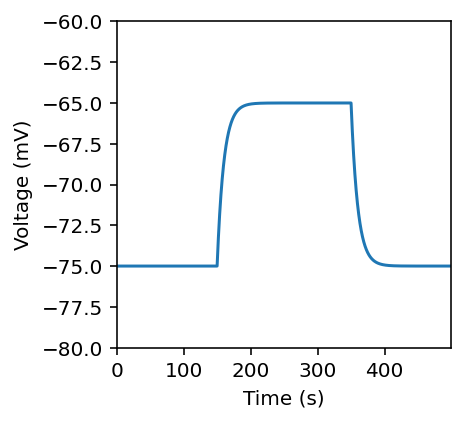

In [4]:
def run_LIF(pars, Iinj, stop=False):
  """
  Simulate the LIF dynamics with external input current
  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value
                 or an array
    stop       : boolean. If True, use a current pulse
  Returns:
    rec_v      : membrane potential
    rec_sp     : spike times
  """
  # Set parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tref = pars['tref']

  # Initialize voltage and current
  v = np.zeros(Lt)
  v[0] = V_init
  Iinj = Iinj * np.ones(Lt)
  if stop:  # set end of current to 0 if current pulse
    Iinj[:int(len(Iinj) / 2) - 1000] = 0
    Iinj[int(len(Iinj) / 2) + 1000:] = 0
  tr = 0.  # the count for refractory duration

  # Simulate the LIF dynamics
  rec_spikes = []  # record spike times
  for it in range(Lt - 1):
    if tr > 0:  # check for refractoriness
      v[it] = V_reset
      tr = tr - 1
    elif v[it] >= V_th:  # reset voltage and record spike event
      rec_spikes.append(it)
      v[it] = V_reset
      tr = tref / dt

    # calculate the increment of the membrane potential
    dv = (-(v[it] - E_L) + Iinj[it] / g_L) * (dt / tau_m)

    # update the membrane potential
    v[it + 1] = v[it] + dv

  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes


pars = default_pars(T=500)
# Uncomment below to test your function
v, sp = run_LIF(pars, Iinj=100, stop=True)
tt = np.arange(0,pars['T'],pars['dt'])
fig=plt.figure(figsize=(3,3))
plt.plot(tt, v)
plt.scatter(sp,20*np.ones(len(sp)))
plt.xlim([0,tt[-1]])
plt.ylim([-80, -60])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

### try changing the parameters? 

In [5]:
# Comment the line below the run your code
raise NotImplementedError('Choose the key you want to change: ')
# change the default parameters
pars = default_pars(...) ### ??? choose the "key" you want to change

# Run the model to obtain v and sp
v, sp = run_LIF(pars, Iinj=...)
tt = np.arange(0,pars['T'],pars['dt'])

# figure setting
fig=plt.figure(figsize=(3,3))
plt.plot(tt, v)
plt.scatter(sp,20*np.ones(len(sp)))
plt.xlim([0,tt[-1]])
plt.ylim([-80, 30])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

NotImplementedError: Choose the key you want to change: 

### example

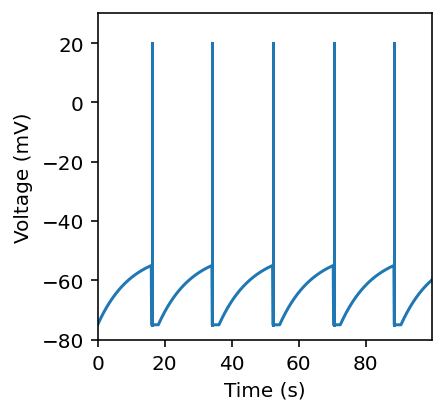

In [6]:
#@title Click to see answer examples
# change the default parameters
pars = default_pars(T=100)

# Run the model to obtain v and sp
v, sp = run_LIF(pars, Iinj=250)
tt = np.arange(0,pars['T'],pars['dt'])
fig=plt.figure(figsize=(3,3))
plt.plot(tt, v)
[plt.plot([sp_time, sp_time], [pars['V_reset'], 20], color='#1f77b4') for sp_time in sp]
plt.xlim([0,tt[-1]])
plt.ylim([-80, 30])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

### How about connecting a simple network with 2 neurons?

neurondict: dict_values([<__main__.LIFneurons object at 0x7fc6e8edc810>, <__main__.LIFneurons object at 0x7fc6e8edc0d0>])


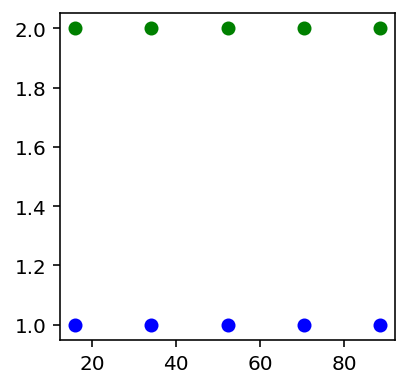

In [10]:
class LIFneurons(object):
    def __init__(self, 
        V_th, V_reset, tau_m, g_L, V_init, E_L, dt, tref,
        **kwargs
    ):
        # variables 
        self.v = V_init
        self.tr= 0
        # Set parameters
        self.V_th, self.V_reset = V_th, V_reset
        self.tau_m, self.g_L = tau_m, g_L
        self.V_init, self.E_L = V_init, E_L
        self.dt = dt
        self.tref = tref
        self.outspk = 0
        self.rec_spike=[]

    def update(self, ext, sd, weightvec,spkvec,t):
        # refractory time period
        self.outspk=0
        if self.tr > 0:
            self.v = self.V_reset
            self.tr-=1
            self.outspk = 0
        elif self.v>self.V_th:
            self.v=self.V_reset
            self.tr = int(self.tref/self.dt)
            self.rec_spike.append(t)
            self.outspk =1
        ff,rc = ext*sd, np.sum(weightvec*spkvec)
        dv = (-(self.v - self.E_L) + (ff+rc) / self.g_L) * (self.dt / self.tau_m)
        # update the membrane potential
        self.v  +=dv
                    
def run_LIF2(pars, Iinj,neuronnum=2, stop=False):
  """
  Simulate the LIF dynamics with external input current
  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value
                 or an array
    stop       : boolean. If True, use a current pulse
  Returns:
    rec_v      : membrane potential
    rec_sp     : spike times
  """
  # Set parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  fig=plt.figure(figsize=(3,3))
  cm='bg'
  # Initialize voltage and current
  v = np.zeros((neuronnum,Lt))
  spikes_mat = np.zeros(neuronnum)
  Iinj = Iinj * np.ones(Lt)
  if stop:  # set end of current to 0 if current pulse
    Iinj[:int(len(Iinj) / 2) - 1000] = 0
    Iinj[int(len(Iinj) / 2) + 1000:] = 0
  tr = 0.  # the count for refractory duration
  neurondict = {}
  for i in range(neuronnum):
      neurondict[i]=LIFneurons(**pars)
  print('neurondict:',neurondict.values())
  neuronlist = neurondict.values()
  # Simulate the LIF2 dynamics
  for it in range(Lt - 1):
    tcurr = dt*it
    idxneuron = 0
    for neuron in neuronlist:
        neuron.update(Iinj[it],1.0,np.zeros(neuronnum),spikes_mat,tcurr)
        idxneuron+=1
    idxneuron = 0
    for neuron in neuronlist:
        spikes_mat[idxneuron]=0
        if neuron.outspk==1:
            spikes_mat[idxneuron]=1
        idxneuron+=1

  idxneuron=0
  for neuron in neuronlist:     
      plt.scatter(neuron.rec_spike,(idxneuron+1)*np.ones(len(neuron.rec_spike)),c=cm[idxneuron])
      idxneuron+=1
  plt.show()
  return neurondict

# check the code 

# n1,n2 = LIFneurons(**pars),LIFneurons(**pars)
# print('default parameters neuron 1 voltage:',n1.v)
# weightmat = np.array([[2,-1],[2,-1]])
# spkvec    = np.array([1,0])
# n1.update(1.0,0.2,weightmat[0,:],spkvec,0.1)
# n2.update(1.0,0.2,weightmat[1,:],spkvec,0.1)
# print('update neuron 1 voltage:',n1.v)
# print('update neuron 2 voltage:',n2.v)

pars = default_pars(T=100)
# Uncomment below to test your function
neurondict = run_LIF2(pars, Iinj=250,neuronnum=2, stop=False)

## Exercise 2: Poisson generator 

### 2.1 Gaussian White Noise current

Given the noisy nature of neuronal activity _in vivo_, neurons usually receive complex, time-varying inputs.

To mimic this, we will now investigate the neuronal response when the LIF neuron receives Gaussian white noise $\xi(t)$ with mean 

\begin{eqnarray}
E[\xi(t)]=\mu=0,
\end{eqnarray}

and autocovariance 
\begin{eqnarray}
E[\xi(t)\xi(t+\tau)]=\sigma_\xi^2 \delta(\tau)
\end{eqnarray}

Note that the GWN has zero mean, that is, it describes only the fluctuations of the input received by a neuron. We can thus modify our definition of GWN to have a nonzero mean value $\mu$ that equals the DC input, since this is the average input into the cell. The cell below defines the modified gaussian white noise currents with nonzero mean $\mu$.

In [26]:
#@markdown Execute this cell to get function to generate GWN

def my_GWN(pars, mu, sig, myseed=False):
  """
  Function that generates Gaussian white noise input

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same
                 random number sequence

  Returns:
    I          : Gaussian white noise input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  # you can fix the seed of the random number generator so that the results
  # are reliable however, when you want to generate multiple realization
  # make sure that you change the seed for each new realization.
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate GWN
  # we divide here by 1000 to convert units to sec.
  I_gwn = mu + sig * np.random.randn(Lt) / np.sqrt(dt / 1000.)

  return I_gwn

### LIF neuron driven by GWM

Text(0, 0.5, '$I_{GWN}$(pA)')

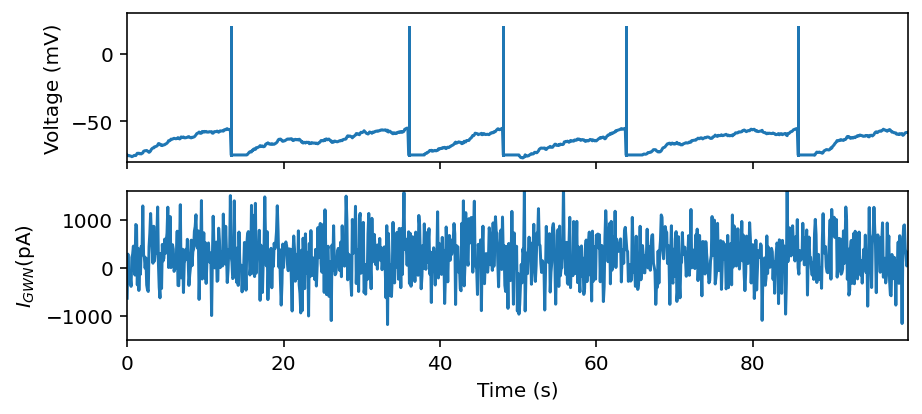

In [32]:
pars = default_pars(T=100.)
sig_gwn = 5.
mu_gwn = 250.

# Calculate the GWN current
I_GWN = my_GWN(pars, mu=mu_gwn, sig=sig_gwn, myseed=2020)

# Run the model and calculate the v and the sp
v, sp = run_LIF(pars, Iinj=I_GWN)

tt = np.arange(0,pars['T'],pars['dt'])
fig,ax=plt.subplots(2,1,figsize=(7,3), sharex=True)
ax[0].plot(tt, v)
[ax[0].plot([sp_time, sp_time], [pars['V_reset'], 20], color='#1f77b4') for sp_time in sp]
ax[0].set_xlim([0,tt[-1]])
ax[0].set_ylim([-80, 30])
ax[0].set_ylabel('Voltage (mV)')

ax[1].plot(tt, I_GWN)
ax[1].set_xlim([0,tt[-1]])
ax[1].set_ylim([-1.5e3, 1.6e3])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel(r'$I_{GWN}$(pA)')

### Generation of Poisson type spike trains

Mathematically, a spike train is a Point Process. One of the simplest models of a sequence of presynaptic pulse inputs is the Poisson process. We know that given temporal integration and refractoriness, neurons cannot behave as a Poisson Process, and Gamma Process gives a better approximation (*find out what might be the difference in the two processes*). 
Here, however, we will assume that the incoming spikes are following Poisson statistics. A question arises about how to simulate a Poisson process. The generation of the Poisson process can be realized by at least two following ways:

- By definition, for a Poisson process with rate $\lambda$, the probability of finding one event in the time window with a sufficiently small length $\Delta t$ is $P(N = 1) = \lambda \Delta t$. Therefore, in each time window, we generate a uniformly distributed random variable $r \in [0,1]$ and generate a Poisson event when $r <\lambda \Delta t$. This method allows us to generate Poisson distributed spikes in an online manner.


- The interval $t_{k+1}-t_{k}$ between two Poisson events with rate $\lambda$ follows the exponential distribution, i.e., $P(t_{k+1}-t_{k}<t) = 1 - e^{\lambda t}$. Therefore, we only need to generate a set of exponentially distributed variables $\{s_k\}$ to obtain the timing of Poisson events $t_{k+1}=t_{k}+s_{k}$. In this method, we need to generate all future spikes at once. 

Below, we use the first method in a function `Poisson_generator`, which takes arguments `(pars, rate, n, myseed)`.

In [16]:
# @markdown Execute this cell to get a Poisson_generator function


def Poisson_generator(pars, rate, n, myseed=False):
  """
  Generates poisson trains

  Args:
    pars            : parameter dictionary
    rate            : noise amplitute [Hz]
    n               : number of Poisson trains
    myseed          : random seed. int or boolean

  Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                      there is a spike in ith spike train over time
                      (1 if spike, 0 otherwise)
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate uniformly distributed random variables
  u_rand = np.random.rand(n, Lt)

  # generate Poisson train
  poisson_train = 1. * (u_rand < rate * (dt / 1000.))

  return poisson_train

poisson train size: (100, 4000)


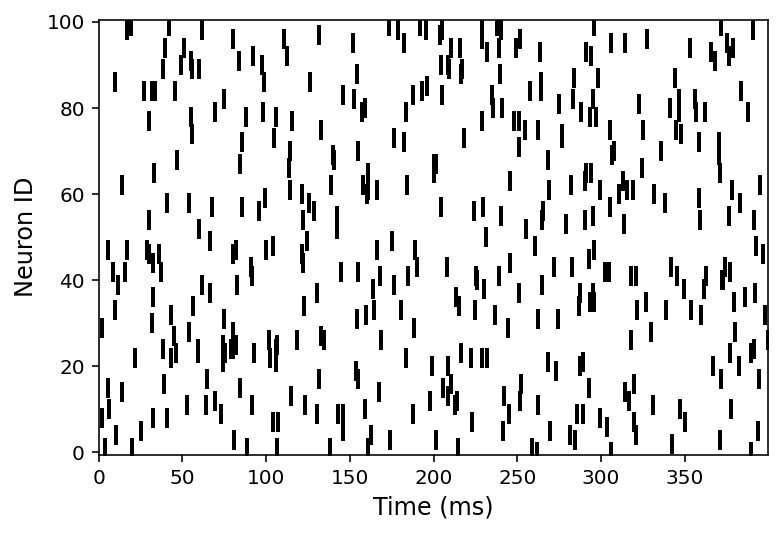

In [17]:
# we can use Poisson_generator to mimic presynaptic spike trains
pars = default_pars()
pre_spike_train = Poisson_generator(pars, rate=10, n=100, myseed=2020)
my_raster_Poisson(pars['range_t'], pre_spike_train, 100)
print('poisson train size:',np.shape(pre_spike_train))

### ISI histogram, is it a Poisson process?

### Example

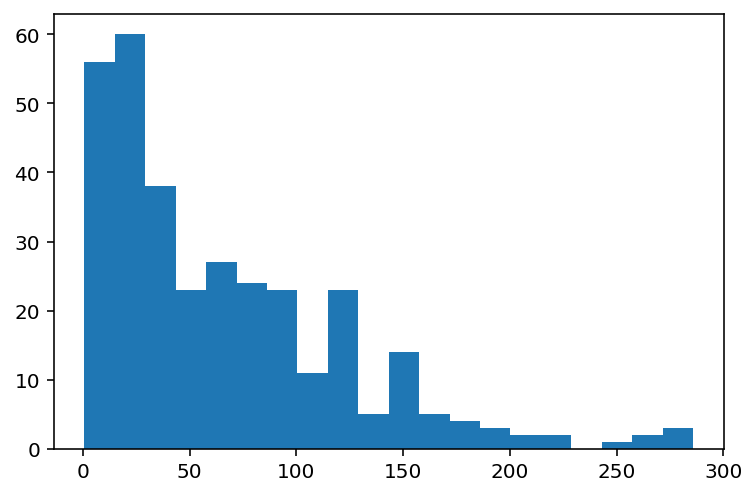

In [74]:
ISI_total = []
for i in range(np.shape(pre_spike_train)[0]):
    # the spike trains
    spike_train   = pre_spike_train[i,:]
    # spike timing
    t_spike       = np.where(spike_train>0)
    # ISI
    ISI_spike     = np.diff(t_spike)*pars['dt']
    ISI_trains[i] = ISI_spike
    ISI_total     = np.append(ISI_total,np.squeeze(ISI_spike))

n,bins,_=plt.hist(ISI_total,bins=20)



## Further Reading
Hu, Y. and Sompolinsky, H., 2020. The spectrum of covariance matrices of randomly connected recurrent neuronal networks. bioRxiv.
https://www.biorxiv.org/content/10.1101/2020.08.31.274936v1.abstract